In [1]:
from src.visualise import settings
from src.visualise.plot import plot_data
from src.data.paths import project_dir
from src.data.analysis import read_tiff_img, Circle, create_circular_mask
from src.data.detector import find_circle_hough_method, img_for_circle_detection

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import re

from dataclasses import dataclass, field
from pathlib import Path

from copy import deepcopy

import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

# Efficiency data

In [2]:
df = pd.read_hdf(project_dir / 'data' / 'interim' / 'data.h5', key='df')
df

,det_no,mean_signal,std_signal,radiation,circle_no
14000,2,289.468354,42.979782,Co60,0
14001,2,305.292453,45.346042,Co60,1
14002,2,296.816456,46.213160,Co60,2
14003,2,297.434921,44.337215,Co60,3
14004,2,292.047923,46.534823,Co60,4
...,...,...,...,...,...
13995,15,8.490446,10.535120,proton,995
13996,15,8.051118,10.144827,proton,996
13997,15,7.241935,9.487658,proton,997
13998,15,7.574132,10.019462,proton,998


In [3]:
df2 = pd.DataFrame()
df2["mean"] = df.groupby(["radiation", "det_no"])["mean_signal"].mean()
df2["std"] = df.groupby(["radiation", "det_no"])["mean_signal"].std()
df2

mean        std
radiation det_no                        
Co60      2        294.177155   5.281284
          3        259.925664   5.172389
          4        307.193718   8.360782
          5        298.560586   4.623326
          6        263.274340   4.998810
          7        306.621866  12.813121
          8        269.288475   4.066825
          9        287.149621   4.713548
          10       289.443222   5.660573
          11       291.733192   6.415302
          12       334.398433   4.508815
          13       304.552993   5.283775
          14       317.976738   5.808940
          15       286.007525   7.678445
proton    2        240.926864   6.203201
          3        218.675780   6.467284
          4        277.420017  11.357313
          5        281.655661  11.541480
          6        261.187590   5.646516
          7        329.770067  21.287917
          8        329.174260   5.681773
          9        403.505165  27.185885
          10       521.933677  23.108895
          11      1028.309760  38.135600
          12       878.400587  75.431505
          13       279.135604  22.178216
          14        39.784106   2.639777
          15         7.425226   0.648031

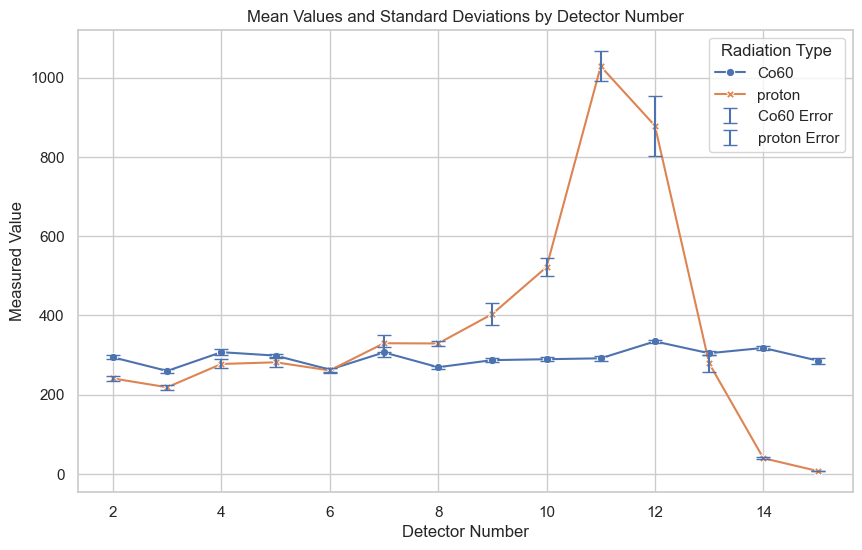

In [4]:
# Reset the index if df2 is a MultiIndex DataFrame
df2_reset = df2.reset_index()

# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Plot the mean values with line and scatter points
sns.lineplot(data=df2_reset, x='det_no', y='mean', hue='radiation', style='radiation', markers=True, dashes=False)

# Add error bars
for radiation_type in df2_reset['radiation'].unique():
    subset = df2_reset[df2_reset['radiation'] == radiation_type]
    plt.errorbar(subset['det_no'], subset['mean'], yerr=subset['std'], fmt='none', capsize=5, label=f'{radiation_type} Error')

plt.title('Mean Values and Standard Deviations by Detector Number')
plt.xlabel('Detector Number')
plt.ylabel('Measured Value')
plt.legend(title='Radiation Type')

# Bragg peak data from dosimetry and MC

In [5]:
base_path = Path('C:\\Users\\grzanka\\OneDrive - ifj.edu.pl\\Projects\\MB_foils\\')
base_path.exists()

True

In [6]:
plots_path = base_path / '2024-05-28_PB_silicon_20Gy' / 'article-plots.h5'
df_bp_exp = pd.read_hdf(plots_path, key='bp_exp')
df_bp_mc = pd.read_hdf(plots_path, key='bp_mc')

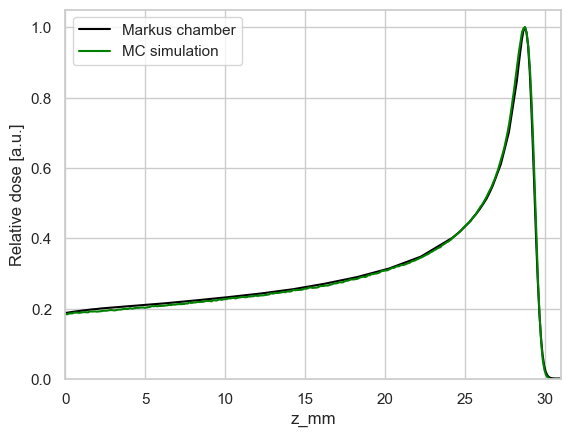

In [7]:
fig, ax_up = plt.subplots(nrows=1, sharex=True)
df_bp_exp.plot(ax=ax_up, x='Depth', y='Signal', label='Markus chamber', color='black', style='-')
df_bp_mc.plot(ax=ax_up, x='z_mm', y='dose', label='MC simulation', color='green', style='-')
ax_up.set_ylim(0,1.05)
ax_up.set_xlim(0, 31)
ax_up.set_ylabel("Relative dose [a.u.]");

# Detector positions

In [8]:
xls_path = base_path / '2024-05-28_PB_silicon_20Gy' / 'Pozycje_det.xlsx'
df_pos = pd.read_excel(xls_path, 
    skiprows=6, 
    nrows=31, 
    usecols="A,C,D,E",
    names=["det_no", "name", "det_thick", "WER"]
    )
# add new column det_start which is sum of WER for all indexes lower than current
df_pos['det_end'] = df_pos.WER.cumsum()
df_pos['det_begin'] = df_pos.det_end - df_pos.WER
df_pos = df_pos[df_pos.name == 'folia MBO']
df_pos.drop("name", axis=1, inplace=True)
df_pos['det_mid'] = (df_pos.det_begin + df_pos.det_end) / 2
df_pos.det_no = df_pos.det_no.astype(int)
df_pos

,det_no,det_thick,WER,det_end,det_begin,det_mid
0,2,0.43,0.4515,0.4515,0.0000,0.22575
3,3,0.43,0.4515,3.7780,3.3265,3.55225
6,4,0.42,0.4410,7.0710,6.6300,6.85050
9,5,0.44,0.4620,10.3850,9.9230,10.15400
12,6,0.44,0.4620,13.4345,12.9725,13.20350
15,7,0.42,0.4410,16.4285,15.9875,16.20800
18,8,0.46,0.4830,19.4875,19.0045,19.24600
21,9,0.43,0.4515,22.4460,21.9945,22.22025
24,10,0.43,0.4515,25.4160,24.9645,25.19025
26,11,0.44,0.4620,28.3965,27.9345,28.16550


In [9]:
# join df_reset with df_pos on det_no
df_reset_pos = df2_reset.join(df_pos.set_index('det_no'), on='det_no')
df_reset_pos

,radiation,det_no,mean,std,det_thick,WER,det_end,det_begin,det_mid
0,Co60,2,294.177155,5.281284,0.43,0.4515,0.4515,0.0000,0.22575
1,Co60,3,259.925664,5.172389,0.43,0.4515,3.7780,3.3265,3.55225
2,Co60,4,307.193718,8.360782,0.42,0.4410,7.0710,6.6300,6.85050
3,Co60,5,298.560586,4.623326,0.44,0.4620,10.3850,9.9230,10.15400
4,Co60,6,263.274340,4.998810,0.44,0.4620,13.4345,12.9725,13.20350
5,Co60,7,306.621866,12.813121,0.42,0.4410,16.4285,15.9875,16.20800
6,Co60,8,269.288475,4.066825,0.46,0.4830,19.4875,19.0045,19.24600
7,Co60,9,287.149621,4.713548,0.43,0.4515,22.4460,21.9945,22.22025
8,Co60,10,289.443222,5.660573,0.43,0.4515,25.4160,24.9645,25.19025
9,Co60,11,291.733192,6.415302,0.44,0.4620,28.3965,27.9345,28.16550


(0.0, 30.0)

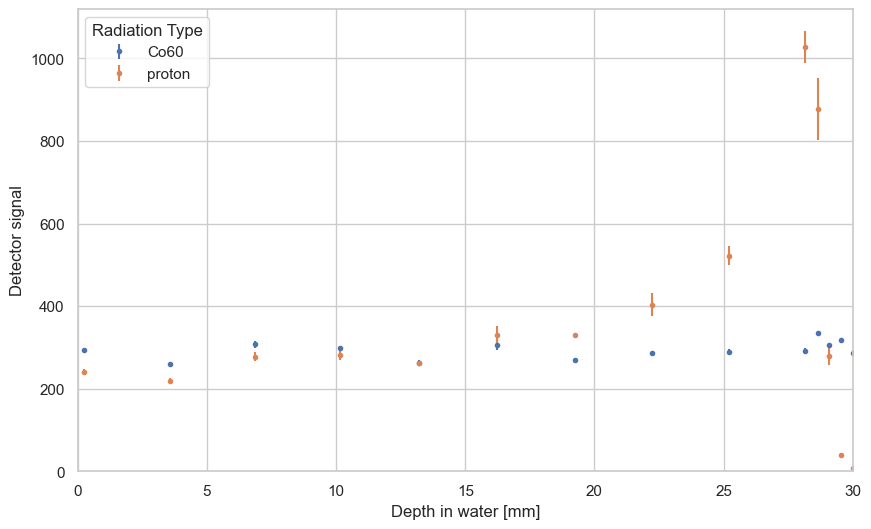

In [10]:
# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Add error bars
for radiation_type in df_reset_pos['radiation'].unique():
    subset = df_reset_pos[df_reset_pos['radiation'] == radiation_type]
    plt.errorbar(subset['det_mid'], subset['mean'], yerr=subset['std'], ls='', marker='.', label=f'{radiation_type}')

plt.xlabel('Depth in water [mm]')
plt.ylabel('Detector signal')
plt.legend(title='Radiation Type')
plt.ylim(0,None)
plt.xlim(0,30)

# Dose per detector

In [11]:
df_bp_mc

,zlower_cm,zupper_cm,dose,r.err,z_mm,dose_Gy
26,0.00,0.01,0.184743,0.0033,0.05,20.000000
27,0.01,0.02,0.184782,0.0034,0.15,20.004237
28,0.02,0.03,0.187052,0.0049,0.25,20.249965
29,0.03,0.04,0.186947,0.0041,0.35,20.238667
30,0.04,0.05,0.187195,0.0049,0.45,20.265499
...,...,...,...,...,...,...
421,3.95,3.96,0.000006,0.4542,39.55,0.000676
422,3.96,3.97,0.000016,0.5727,39.65,0.001760
423,3.97,3.98,0.000025,0.7804,39.75,0.002744
424,3.98,3.99,0.000028,0.7334,39.85,0.003082


In [12]:
# create spline interpolator object from scipy for x = df_bp_mc.z_mm and y = df_bp_mc.dose
from scipy.interpolate import interp1d
f = interp1d(df_bp_mc.z_mm, df_bp_mc.dose, kind='cubic')

In [13]:
df_bp_mc.iloc[0].dose

0.1847426230791307

In [14]:
# for such rows of df_reset_pos where radiation is 'proton' calculate 'dose' as f(df_reset_pos.det_mid)
entrance_dose_protons_Gy = 20
dose_Co60 = 20
df_reset_pos.loc[df_reset_pos.radiation == 'proton', 'dose'] = f(df_reset_pos[df_reset_pos.radiation == 'proton'].det_mid) / df_bp_mc.iloc[0].dose * entrance_dose_protons_Gy
df_reset_pos.loc[df_reset_pos.radiation == 'Co60', 'dose'] = dose_Co60

In [15]:
df_reset_pos['mean_signal_per_Gy'] = df_reset_pos['mean'] / df_reset_pos['dose']
df_reset_pos['std_signal_per_Gy'] = df_reset_pos['std'] / df_reset_pos['dose']
df_reset_pos

,radiation,det_no,mean,std,det_thick,WER,det_end,det_begin,det_mid,dose,mean_signal_per_Gy,std_signal_per_Gy
0,Co60,2,294.177155,5.281284,0.43,0.4515,0.4515,0.0000,0.22575,20.000000,14.708858,0.264064
1,Co60,3,259.925664,5.172389,0.43,0.4515,3.7780,3.3265,3.55225,20.000000,12.996283,0.258619
2,Co60,4,307.193718,8.360782,0.42,0.4410,7.0710,6.6300,6.85050,20.000000,15.359686,0.418039
3,Co60,5,298.560586,4.623326,0.44,0.4620,10.3850,9.9230,10.15400,20.000000,14.928029,0.231166
4,Co60,6,263.274340,4.998810,0.44,0.4620,13.4345,12.9725,13.20350,20.000000,13.163717,0.249941
5,Co60,7,306.621866,12.813121,0.42,0.4410,16.4285,15.9875,16.20800,20.000000,15.331093,0.640656
6,Co60,8,269.288475,4.066825,0.46,0.4830,19.4875,19.0045,19.24600,20.000000,13.464424,0.203341
7,Co60,9,287.149621,4.713548,0.43,0.4515,22.4460,21.9945,22.22025,20.000000,14.357481,0.235677
8,Co60,10,289.443222,5.660573,0.43,0.4515,25.4160,24.9645,25.19025,20.000000,14.472161,0.283029
9,Co60,11,291.733192,6.415302,0.44,0.4620,28.3965,27.9345,28.16550,20.000000,14.586660,0.320765


(0.0, 30.0)

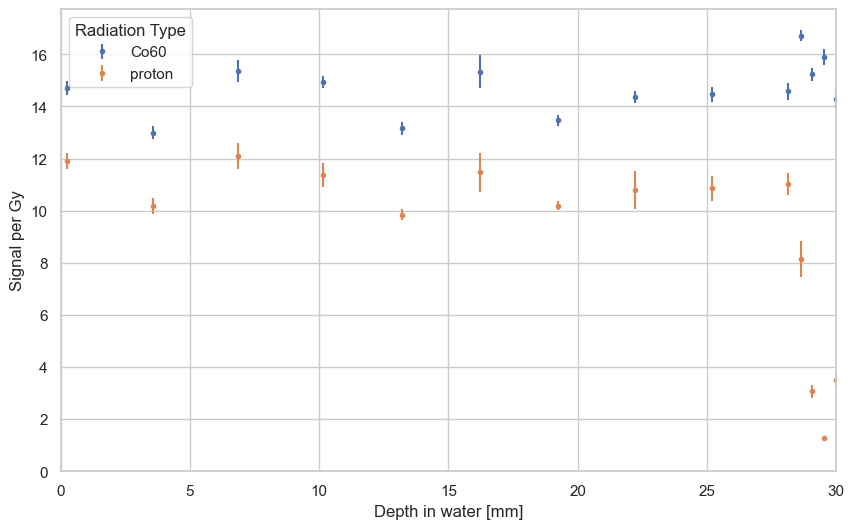

In [16]:
# Create a figure and axis object
plt.figure(figsize=(10, 6))

# Add error bars
for radiation_type in df_reset_pos['radiation'].unique():
    subset = df_reset_pos[df_reset_pos['radiation'] == radiation_type]
    plt.errorbar(subset['det_mid'], subset['mean_signal_per_Gy'], yerr=subset['std_signal_per_Gy'], ls='', marker='.', label=f'{radiation_type}')

plt.xlabel('Depth in water [mm]')
plt.ylabel('Signal per Gy')
plt.legend(title='Radiation Type')
plt.ylim(0,None)
plt.xlim(0,30)

In [17]:
co60_data = df_reset_pos.loc[df_reset_pos.radiation == 'Co60']
proton_data = df_reset_pos.loc[df_reset_pos.radiation == 'proton']
all_data = co60_data.merge(proton_data, on='det_no', suffixes=['_Co60', '_proton'])
all_data['mean_efficiency'] = all_data['mean_signal_per_Gy_proton'] / all_data['mean_signal_per_Gy_Co60']
numerator_relative_std = all_data['std_signal_per_Gy_proton'] / all_data['mean_signal_per_Gy_Co60']
denominator_term = all_data['mean_signal_per_Gy_proton'] * all_data['std_signal_per_Gy_Co60'] / (all_data['mean_signal_per_Gy_Co60']**2)
all_data['std_efficiency'] = numerator_relative_std + denominator_term

In [18]:
all_data = all_data[all_data.det_no < 14]

(0.0, 30.0)

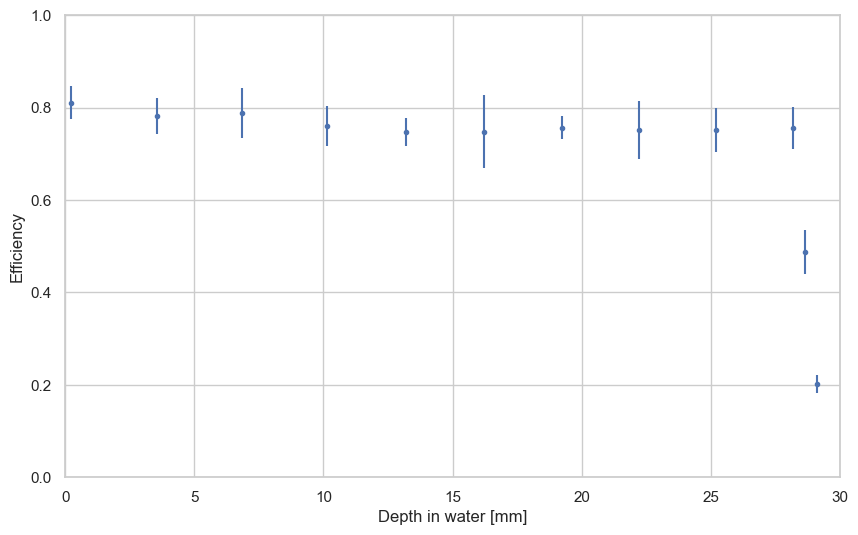

In [19]:
plt.figure(figsize=(10, 6))
plt.errorbar(all_data['det_mid_proton'], all_data['mean_efficiency'], yerr=all_data['std_efficiency'], ls='', marker='.', label=f'efficiency')
plt.xlabel('Depth in water [mm]')
plt.ylabel('Efficiency')
plt.ylim(0,1)
plt.xlim(0,30)

# Kinetic energy

In [20]:
df_bp_kin_en = pd.read_hdf(plots_path, key='bp_kin_en')

In [21]:
from scipy.interpolate import UnivariateSpline
bp_kin_en_spl = UnivariateSpline(df_bp_kin_en.z_mm.values, df_bp_kin_en.ef_q50.values)

In [22]:
all_data['ekin_MeV'] = bp_kin_en_spl(all_data['det_mid_proton'])

In [23]:
all_data

,radiation_Co60,det_no,mean_Co60,std_Co60,det_thick_Co60,WER_Co60,det_end_Co60,det_begin_Co60,det_mid_Co60,dose_Co60,...,WER_proton,det_end_proton,det_begin_proton,det_mid_proton,dose_proton,mean_signal_per_Gy_proton,std_signal_per_Gy_proton,mean_efficiency,std_efficiency,ekin_MeV
0,Co60,2,294.177155,5.281284,0.43,0.4515,0.4515,0.0000,0.22575,20.0,...,0.4515,0.4515,0.0000,0.22575,20.206402,11.923294,0.306992,0.810620,0.035424,58.253154
1,Co60,3,259.925664,5.172389,0.43,0.4515,3.7780,3.3265,3.55225,20.0,...,0.4515,3.7780,3.3265,3.55225,21.506662,10.167816,0.300711,0.782363,0.038707,53.373918
2,Co60,4,307.193718,8.360782,0.42,0.4410,7.0710,6.6300,6.85050,20.0,...,0.4410,7.0710,6.6300,6.85050,22.921722,12.102931,0.495483,0.787967,0.053704,49.281308
3,Co60,5,298.560586,4.623326,0.44,0.4620,10.3850,9.9230,10.15400,20.0,...,0.4620,10.3850,9.9230,10.15400,24.802316,11.356023,0.465339,0.760718,0.042952,45.455507
4,Co60,6,263.274340,4.998810,0.44,0.4620,13.4345,12.9725,13.20350,20.0,...,0.4620,13.4345,12.9725,13.20350,26.543545,9.839966,0.212727,0.747507,0.030353,41.760400
5,Co60,7,306.621866,12.813121,0.42,0.4410,16.4285,15.9875,16.20800,20.0,...,0.4410,16.4285,15.9875,16.20800,28.764070,11.464653,0.740087,0.747804,0.079523,37.596526
6,Co60,8,269.288475,4.066825,0.46,0.4830,19.4875,19.0045,19.24600,20.0,...,0.4830,19.4875,19.0045,19.24600,32.321206,10.184467,0.175791,0.756398,0.024479,32.495457
7,Co60,9,287.149621,4.713548,0.43,0.4515,22.4460,21.9945,22.22025,20.0,...,0.4515,22.4460,21.9945,22.22025,37.403185,10.787989,0.726833,0.751385,0.062958,26.283384
8,Co60,10,289.443222,5.660573,0.43,0.4515,25.4160,24.9645,25.19025,20.0,...,0.4515,25.4160,24.9645,25.19025,48.029588,10.866920,0.481139,0.750884,0.047931,18.533086
9,Co60,11,291.733192,6.415302,0.44,0.4620,28.3965,27.9345,28.16550,20.0,...,0.4620,28.3965,27.9345,28.16550,93.240532,11.028570,0.409002,0.756072,0.044666,8.876182


(0.0, 60.0)

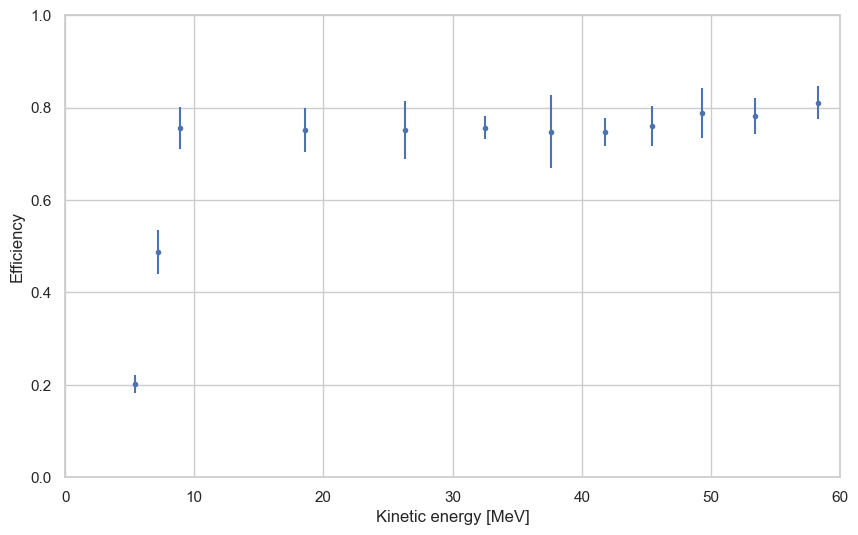

In [24]:
plt.figure(figsize=(10, 6))
plt.errorbar(all_data['ekin_MeV'], all_data['mean_efficiency'], yerr=all_data['std_efficiency'], ls='', marker='.', label=f'efficiency')
plt.xlabel('Kinetic energy [MeV]')
plt.ylabel('Efficiency')
plt.ylim(0,1)
plt.xlim(0,60)

In [25]:
import lmfit
from lmfit.models import StepModel, LinearModel
x_values_for_fit = all_data['ekin_MeV']
y_values_for_fit = all_data['mean_efficiency']
#mod = StepModel(form='logistic')
step_mod = StepModel(form='atan')
#lin_mod = LinearModel()
pars = step_mod.guess(y_values_for_fit, x=x_values_for_fit)
#pars += lin_mod.guess(y_values_for_fit, x=x_values_for_fit)
#pars['intercept'].min = 1e-5
#pars['amplitude'].min = 1e-5
#mod = step_mod + lin_mod
mod = step_mod
out = mod.fit(y_values_for_fit, pars, x=x_values_for_fit)
x_for_plotting = np.linspace(0,60,num=100)
y_for_plotting = out.eval(x=x_for_plotting)
print(out.fit_report(min_correl=0.25))

[[Model]]
    Model(step, form='atan')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 12
    # variables        = 3
    chi-square         = 0.01128973
    reduced chi-square = 0.00125441
    Akaike info crit   = -77.6252209
    Bayesian info crit = -76.1705010
    R-squared          = 0.96682415
[[Variables]]
    amplitude:  0.78121312 +/- 0.01211835 (1.55%) (init = 0.6093602)
    center:     6.59869504 +/- 0.17171529 (2.60%) (init = 31.83538)
    sigma:      1.00690535 +/- 0.20418169 (20.28%) (init = 7.547935)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, sigma) = +0.2867


(0.0, 1.0)

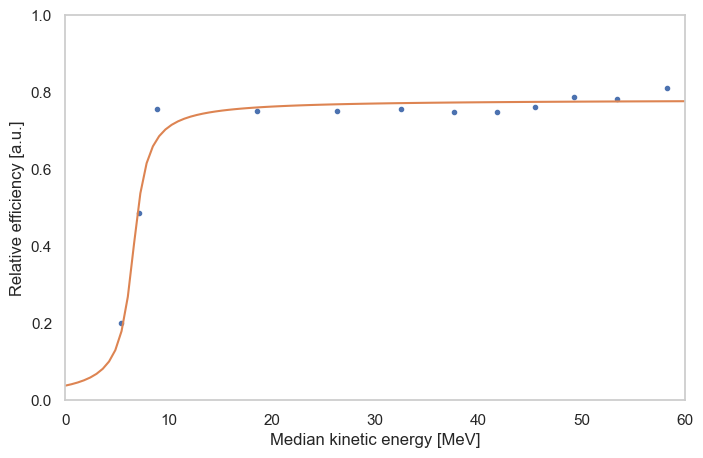

In [26]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(all_data['ekin_MeV'], all_data['mean_efficiency'], marker=".", linestyle="")
ax.plot(x_for_plotting, y_for_plotting)
ax.set_xlabel('Median kinetic energy [MeV]')
ax.set_ylabel('Relative efficiency [a.u.]')
ax.set_xlim(0,60)
ax.grid()
ax.set_ylim(0,1)